# Importamos bibliotecas necesarias

In [1]:
from sys import maxsize #para imprimir arrays completos
import numpy as np
import pandas as pd

from sklearn import preprocessing #para normalizar datos
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Para importar Notebooks propias

##### Desde Jupyter no se importar archivos python planos, sino notebooks que tienen una codificación mas complicada. Para poder importar una notebook correctamente hay que agregar los siguientes métodos (tomado de https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html)

In [2]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [3]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [4]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [5]:

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [6]:
sys.meta_path.append(NotebookFinder())

# Importamos biblioteca propia

In [7]:
#luego de ejecutar las celdas anteriores, se puede importar la biblioteca propia
#si da errores, probar con hacer restart del kernel
import Desafio_2_aux

importing Jupyter notebook from Desafio_2_aux.ipynb


# Leer el data set desde el archivo csv

In [8]:
pathArchivoDataSet = 'properatti_2.csv'
df = pd.read_csv(pathArchivoDataSet)

In [9]:
df.head(5)

,property_type,place_name,state_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,parrilla
0,PH,mataderos,Capital Federal,62000.0,40.000000,15.0,1127.272727,2.0,-34.666326,-58.519094,0,0,0,0,0
1,apartment,la plata,Bs.As. G.B.A. Zona Sur,150000.0,69.891566,0.0,2146.181693,3.0,-34.924277,-57.965973,0,1,1,0,0
2,apartment,mataderos,Capital Federal,72000.0,55.000000,0.0,1309.090909,2.0,-34.666326,-58.519094,0,0,0,0,0
3,PH,liniers,Capital Federal,95000.0,92.565511,0.0,1026.300175,3.0,-34.643508,-58.516984,0,0,0,0,0
4,apartment,centro,Buenos Aires Costa Atlántica,64000.0,35.000000,0.0,1828.571429,4.0,-38.000247,-57.547260,0,0,0,0,0


# Hacemos un análisis de la correlación entre las variables del data frame

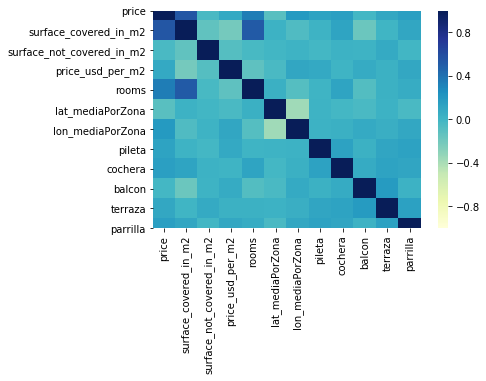

In [10]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, center=0, cmap="YlGnBu");

# Definimos el subset de datos del cual generaremos el modelo

### Nos quedamos con el subset de datos relacionados a Capital Federal

In [11]:

filtroParaElSubsetDeDatos = ['Córdoba']

In [12]:
df_subset = Desafio_2_aux.getSubDataFrameByStateName(df, filtroParaElSubsetDeDatos)

Sub data frame Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10704 entries, 10 to 109281
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   property_type              10704 non-null  object 
 1   place_name                 10704 non-null  object 
 2   price                      10704 non-null  float64
 3   surface_covered_in_m2      10704 non-null  float64
 4   surface_not_covered_in_m2  10704 non-null  float64
 5   price_usd_per_m2           10704 non-null  float64
 6   rooms                      10704 non-null  float64
 7   lat_mediaPorZona           10704 non-null  float64
 8   lon_mediaPorZona           10704 non-null  float64
 9   pileta                     10704 non-null  int64  
 10  cochera                    10704 non-null  int64  
 11  balcon                     10704 non-null  int64  
 12  terraza                    10704 non-null  int64  
 13  parrilla             

# Analizamos outliers y los sacamos del data frame

### Vemos la distribucion de los datos en gráficos para tratar de identificar los outliers que tenemos

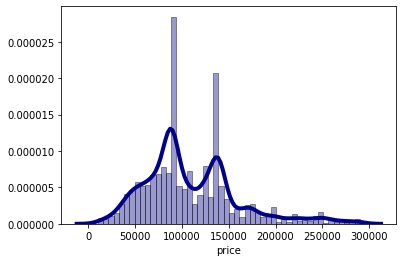

In [13]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'price')


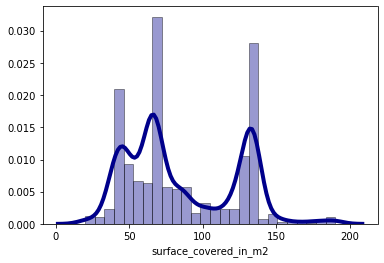

In [14]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'surface_covered_in_m2')

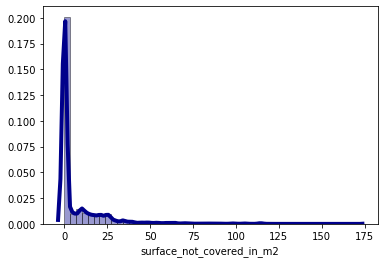

In [15]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'surface_not_covered_in_m2')

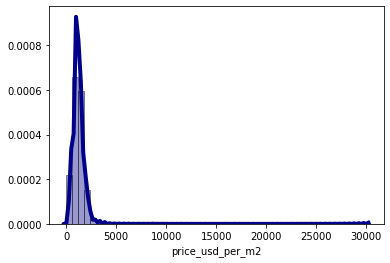

In [16]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'price_usd_per_m2')

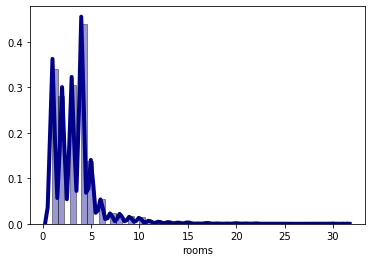

In [17]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'rooms')

### Removemos los outliers

In [18]:
df_subset.describe()

,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,parrilla
count,10704.000000,10704.000000,10704.000000,10704.000000,10704.000000,10704.000000,10704.000000,10704.000000,10704.000000,10704.000000,10704.000000,10704.000000
mean,109148.613948,85.365116,7.495237,1207.041432,3.418909,-31.445562,-64.243217,0.121730,0.289985,0.174421,0.195067,0.009249
std,50241.257444,37.095209,15.827699,647.239659,2.476492,0.276729,0.289787,0.326989,0.453776,0.379489,0.396271,0.095730
min,10317.460317,20.000000,0.000000,12.254902,1.000000,-37.601995,-68.786173,0.000000,0.000000,0.000000,0.000000,0.000000
25%,76932.780000,55.000000,0.000000,878.829256,2.000000,-31.420413,-64.203046,0.000000,0.000000,0.000000,0.000000,0.000000
50%,95000.000000,70.000000,0.000000,1166.903920,3.000000,-31.420413,-64.203046,0.000000,0.000000,0.000000,0.000000,0.000000
75%,138420.123225,128.545288,10.000000,1461.542932,4.000000,-31.420413,-64.203046,0.000000,1.000000,0.000000,0.000000,0.000000
max,290000.000000,190.000000,170.000000,30000.000000,31.000000,-30.519684,-58.275535,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
#removemos datos por outliers de precio por m2
df_subset = Desafio_2_aux.removeRowsWithOutliersFromDataFrame(df_subset, 'price_usd_per_m2', 500, 2500)

In [20]:
#removemos outliers por rooms
df_subset = Desafio_2_aux.removeRowsWithOutliersFromDataFrame(df_subset, 'rooms', 1, 5)

In [21]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   property_type              8623 non-null   object 
 1   place_name                 8623 non-null   object 
 2   price                      8623 non-null   float64
 3   surface_covered_in_m2      8623 non-null   float64
 4   surface_not_covered_in_m2  8623 non-null   float64
 5   price_usd_per_m2           8623 non-null   float64
 6   rooms                      8623 non-null   float64
 7   lat_mediaPorZona           8623 non-null   float64
 8   lon_mediaPorZona           8623 non-null   float64
 9   pileta                     8623 non-null   int64  
 10  cochera                    8623 non-null   int64  
 11  balcon                     8623 non-null   int64  
 12  terraza                    8623 non-null   int64  
 13  parrilla                   8623 non-null   int64

### Vemos como quedaron los resultados

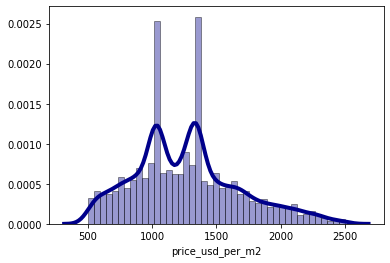

In [22]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'price_usd_per_m2')

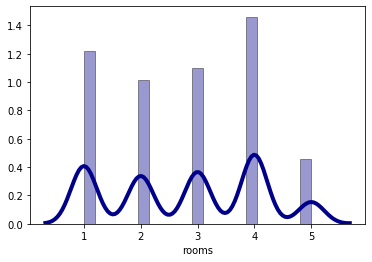

In [23]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'rooms')

# Analizamos las variables categóricas

córdoba                    6906
punilla                     484
villa carlos paz            335
villa allende               178
santa maría                 114
                           ... 
balnearia                     1
la cumbrecita                 1
villa cerro azul              1
villa ciudad de américa       1
laboulaye                     1
Name: place_name, Length: 77, dtype: int64


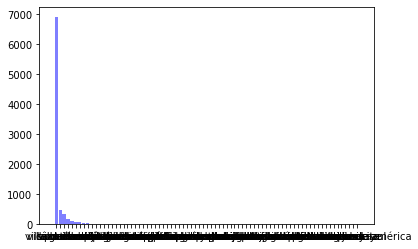

apartment    5101
house        2850
store         348
PH            324
Name: property_type, dtype: int64


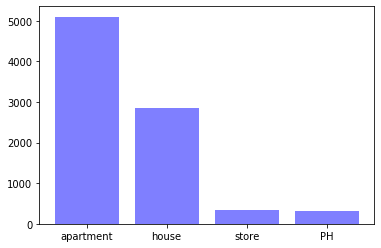

In [24]:
Desafio_2_aux.analyzeCategoricalData(df_subset, ['place_name', 'property_type'])

### Creamos variables dummies a partir de la variable categorica

In [25]:
df_subset = Desafio_2_aux.createDummiesForVariables(df_subset, ['place_name', 'property_type'])

In [26]:
df_subset.head()

,property_type,place_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,...,place_name_villa giardino,place_name_villa la bolsa,place_name_villa los aromos,place_name_villa maría,place_name_villa parque siquiman,place_name_villa rumipal,place_name_villa santa cruz del lago,property_type_apartment,property_type_house,property_type_store
0,house,córdoba,70000.000000,134.014337,0.0,522.332174,4.0,-31.420413,-64.203046,0,...,0,0,0,0,0,0,0,0,1,0
1,house,villa giardino,142500.000000,148.000000,0.0,962.837838,5.0,-31.051430,-64.497877,0,...,1,0,0,0,0,0,0,0,1,0
2,apartment,córdoba,30846.020000,50.000000,0.0,616.920400,3.0,-31.420413,-64.203046,0,...,0,0,0,0,0,0,0,1,0,0
3,house,malagueño,70104.590000,75.000000,0.0,934.727867,4.0,-31.458349,-64.377134,0,...,0,0,0,0,0,0,0,0,1,0
4,apartment,villa carlos paz,86776.236614,115.000000,0.0,754.575971,4.0,-31.436755,-64.497400,0,...,0,0,0,0,0,0,0,1,0,0


# Guardamos un data frame auxiliar con la relacion entre los dummies y el dato place_name

### Data frame auxiliar para place name

In [27]:
place_name_dummies = Desafio_2_aux.generateAuxiliarDataFrameForDummies(df_subset, 'place_name')
place_name_dummies

,place_name,place_name_agua de oro,place_name_alta gracia,place_name_anisacate,place_name_ascochinga,place_name_balnearia,place_name_bell ville,place_name_bialet massé,place_name_capilla del monte,place_name_casa grande,...,place_name_villa del dique,place_name_villa del totoral,place_name_villa general belgrano,place_name_villa giardino,place_name_villa la bolsa,place_name_villa los aromos,place_name_villa maría,place_name_villa parque siquiman,place_name_villa rumipal,place_name_villa santa cruz del lago
0,córdoba,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,villa giardino,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,malagueño,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,villa carlos paz,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,punilla,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7400,villa parque siquiman,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7453,villa de soto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7492,pilar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7794,los cocos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data frame auxiliar para property_type

In [28]:
proeprty_type_dummies = Desafio_2_aux.generateAuxiliarDataFrameForDummies(df_subset, 'property_type')
proeprty_type_dummies

,property_type,property_type_apartment,property_type_house,property_type_store
0,house,0,1,0
2,apartment,1,0,0
12,PH,0,0,0
13,store,0,0,1


# Generamos el objeto para el K Fold

In [29]:
#generamos un K Fold de 5 pasos para el entrenamiento de los modelos
cv = KFold(5, shuffle=True, random_state=10)

# Quitamos las columnas que no van a estar en el modelo

In [30]:
#quitamos las columnas que no van a participar en el modelo
df_model_columns = df_subset.drop(labels= ["price", "property_type", "place_name"], axis=1)
df_model_columns

,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,...,place_name_villa giardino,place_name_villa la bolsa,place_name_villa los aromos,place_name_villa maría,place_name_villa parque siquiman,place_name_villa rumipal,place_name_villa santa cruz del lago,property_type_apartment,property_type_house,property_type_store
0,134.014337,0.0,522.332174,4.0,-31.420413,-64.203046,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,148.000000,0.0,962.837838,5.0,-31.051430,-64.497877,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,50.000000,0.0,616.920400,3.0,-31.420413,-64.203046,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,75.000000,0.0,934.727867,4.0,-31.458349,-64.377134,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,115.000000,0.0,754.575971,4.0,-31.436755,-64.497400,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8618,52.000000,0.0,1619.955385,1.0,-31.420413,-64.203046,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8619,50.000000,0.0,1680.266800,1.0,-31.420413,-64.203046,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8620,52.000000,0.0,1625.348077,1.0,-31.420413,-64.203046,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8621,50.000000,0.0,1684.753600,1.0,-31.420413,-64.203046,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Analisis de correlacion de datos

In [31]:
Desafio_2_aux.showCorrelatedData(df_model_columns, -0.5, 0.5)

surface_covered_in_m2                       surface_covered_in_m2                         1.000000
                                            property_type_house                           0.836586
surface_not_covered_in_m2                   surface_not_covered_in_m2                     1.000000
price_usd_per_m2                            price_usd_per_m2                              1.000000
rooms                                       rooms                                         1.000000
lat_mediaPorZona                            lat_mediaPorZona                              1.000000
lon_mediaPorZona                            lon_mediaPorZona                              1.000000
pileta                                      pileta                                        1.000000
cochera                                     cochera                                       1.000000
balcon                                      balcon                                        1.000000
terraza   

En el modelo se detectan las siguientes correlaciones:

surface_covered_in_m2--property_type_apartment

lat_mediaPorZona--place_name_miramar

lat_mediaPorZona--place_name_río cuarto

property_type_apartment--surface_covered_in_m2

property_type_apartment--property_type_house

In [32]:
#eliminamos una de las columnas de los pares de correlacion
df_model_columns_no_corr = df_model_columns.drop(labels=['property_type_apartment','place_name_miramar',\
                                                         'place_name_río cuarto'], axis=1)

# Generamos un modelo con Regresion Lineal

In [55]:
#definimos como variables para entrenamiento todas las del data frame excepto el precio por m2
#el valor precio por m2 será lo que el modelo intente calcular
X = df_model_columns_no_corr.drop('price_usd_per_m2', axis=1)
y = df_model_columns_no_corr['price_usd_per_m2']

In [60]:
#seleccionamos un tamaño para el set de test del 10% del data frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

### Realizamos un entrenamiento con el k fold con k = 5

In [61]:
#el metodo devuelve el modelo, las predicciones y un data frame para comparar valores reales vs obtenidos
regresionLineal_model, regresionLineal_predicciones, df_regresion_lineal_prediccion_vs_real, scores_lineal = \
                Desafio_2_aux.generateSimpleLinearRegression(X_train, X_test, y_train, y_test, cv)

Score regresión lineal con 5-fold: [-7.59774674e+25 -7.82220003e+25 -1.36489839e+23 -3.05792092e+02
 -8.25561228e+22]



Intercept: 
1263.579623827058



Coeficientes: 
[-1.41833004e+02 -1.08072791e+02 -1.16658374e+00 -4.45502284e+02
 -3.45062565e+02  4.88025763e+01  9.67695622e+00  4.29474722e+00
  9.81727365e+00 -2.37357299e+00  9.33980114e+01  1.10723067e+02
  6.91290772e+01  8.51316993e+01  7.60314997e+01  5.39292100e+01
  4.98838844e+01  9.73330527e+01  5.25266054e+01  1.03949162e+02
  8.35940846e+01  1.06105429e+02  5.79960859e+01  1.47939483e+03
  3.10070615e+01  4.70311758e+01  6.39352472e+01  1.75301781e+02
  3.53172879e+02  6.16574353e+01  2.06555693e+01  9.54138266e+01
  8.62831284e+01  3.81965259e+01 -9.67313185e+00  3.56123765e+01
  4.79691738e+01  1.75839683e+01  9.63402152e+01  4.69993824e+01
  1.48917585e+01  3.54854333e+01  9.43173392e+01  9.06946245e+01
  8.41438951e+01  2.89142846e+02  6.16041769e+01  1.64947484e+01
  3.47075893e+01  8.80251011e+01  4.82532964e+01  7

In [36]:
df_regresion_lineal_prediccion_vs_real

,Real,Predichos,Diferencia
5100,736.861042,1242.678859,-505.817817
6798,914.724203,1368.513721,-453.789517
5305,1537.778226,1462.623146,75.155079
7328,885.394854,597.766340,287.628514
7906,828.960609,1202.983147,-374.022537
...,...,...,...
3671,2221.920608,1476.599023,745.321585
7575,550.528315,1347.073076,-796.544762
7751,1812.221131,1360.938282,451.282848
4702,2099.656759,1110.382374,989.274385


# Redefinimos los data frames para modelar, ya que ahora necesitamos un subconjunto de prueba sobre el data frame total

In [37]:
#seleccionamos un tamaño para el set de test del 25% del data frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

# Generamos el modelo para Ridge Cross Validation

In [38]:
#el metodo devuelve el modelo, las predicciones y un data frame para comparar valores reales vs obtenidos
model_ridge, RidgeCV_predicciones, df_ridge_prediccion_vs_real, model_ridge_score = \
                Desafio_2_aux.generateRidgeCV(X_train, X_test, y_train, y_test, np.linspace(0.001,1,300), cv)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Score Ridge CV: [0.01219621 0.1870518  0.15594761 0.18864088 0.15220432]
Alpha Ridge CV: 1.0
Coeficientes:  [-1.39319611e+02 -1.08934314e+02 -2.92612970e+00  3.80943373e+00
  3.67741719e+00  4.82269709e+01  1.04121025e+01  6.04334646e+00
  1.09254558e+01  8.58672009e-02  2.22598667e+00  7.34228046e+00
  7.69097515e+00  1.33232276e+01  0.00000000e+00 -1.87057800e+00
 -6.64920966e+00  3.74501811e+00  1.01695626e+01 -2.56599377e+00
  1.79613260e+00 -1.97139679e+00  1.06230445e+01  1.22642632e+01
 -2.06144283e-02  1.29495915e+00  7.59876632e-01  4.14913868e+00
 -1.90786683e+01 -5.46994616e+00 -6.67918207e-01 -2.10070650e+00
 -2.76422574e+00 -8.89136528e+00 -3.45360915e+00  1.17346636e+00
 -1.02466386e+01  3.29831776e+00 -1.19901881e+00 -9.87078900e-01
 -3.09181130e+00 -3.81908640e-01  5.50133973e+00 -1.07907685e+01
 -5.24632443e+00  1.51199244e+00 -5.64184266e+00  0.00000000e+00
 -3.83962882e+00  1.64068059e+00  8.10497425e-02 -1.69100517e+01
 -2.58747205e+00 -2.15204258e-01 -6.77647074e-0

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [39]:
df_ridge_prediccion_vs_real

,Real,Predichos,Diferencia
5100,736.861042,1240.303621,-503.442579
6798,914.724203,1368.931934,-454.207731
5305,1537.778226,1461.757895,76.020330
7328,885.394854,513.783405,371.611449
7906,828.960609,1236.696610,-407.736000
...,...,...,...
815,889.210402,681.512546,207.697857
3921,1032.875485,1097.066107,-64.190622
5421,953.422500,1226.035521,-272.613021
3274,1306.419765,1209.482092,96.937673


# Generamos el modelo para Lasso Cross Validation

In [40]:
model_lasso, LassoCV_predicciones, df_lasso_prediccion_vs_real, scores_lasso = \
        Desafio_2_aux.generateLassoCV(X_train, X_test, y_train, y_test, np.linspace(0.001,1,300), cv)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66692.83428752422, tolerance: 58634.51424015277
  tol, rng, random, positive)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  war




Intercept: 



1264.2069522773918



Coeficientes: 



[-130.33202946 -102.06660072   -0.            0.51009309   -0.
   45.90021686    4.43321679    2.25593964    6.92511269    0.
    0.            2.95879978    3.25813691    8.98063217    0.
   -0.           -2.52814768    0.            5.89562738   -0.
    0.           -0.            6.36829055   12.58170587    0.
    0.            0.            0.16868882  -15.1406078    -1.28378644
   -0.           -0.           -0.           -4.53057679   -0.
    0.           -5.80189682    0.           -0.           -0.
   -0.           -0.            0.91131933   -6.02818868   -0.18176104
    0.           -2.40496346    0.           -0.            0.
   -0.          -12.51094927   -0.           -0.           -0.
   -0.72545844    0.           -0.           -0.           -2.3100423
    2.66894404   -0.8473523    -2.90980505   -0.           -0.
   21.67686755   -0.           -0.           -2.54764994   -0.
   16.69469945   -1.42397158    0.   

##### Vemos que el modelo lasso seleccionó algunos coeficientes para no ser incluidos en el modelo, aquellos que valen 0

In [62]:
model_lasso.alpha_

4.176820322148338

In [41]:
df_lasso_prediccion_vs_real

,Real,Predichos,Diferencia
5100,736.861042,1251.465513,-514.604470
6798,914.724203,1364.213940,-449.489737
5305,1537.778226,1459.043207,78.735019
7328,885.394854,575.328188,310.066666
7906,828.960609,1111.115788,-282.155179
...,...,...,...
815,889.210402,755.047332,134.163071
3921,1032.875485,1107.470764,-74.595279
5421,953.422500,1228.120293,-274.697793
3274,1306.419765,1224.848410,81.571355


# Verificamos los resultados

### Visualizamos los scores de los modelos

In [42]:
print("Score Train Lineal: " ,scores_lineal)
print("Score Train Ridge: " , model_ridge_score)
print("Score Train Lasso: " ,  scores_lasso)

Score Train Lineal:  [-2.07354124e+26 -1.49606778e+26 -5.01954753e+26 -4.15465268e+23
 -6.79166901e+25]
Score Train Ridge:  [0.01219621 0.1870518  0.15594761 0.18864088 0.15220432]
Score Train Lasso:  [0.16262743 0.19441469 0.15581813 0.18867615 0.1552555 ]


### Visualizamos los errores cuadraticos medios

In [43]:
print("Test RMSE Lineal: " + str(np.sqrt(metrics.mean_squared_error(df_regresion_lineal_prediccion_vs_real.Real, df_regresion_lineal_prediccion_vs_real.Predichos))))
print("Test RMSE RidgeCV: " + str(np.sqrt(metrics.mean_squared_error(df_ridge_prediccion_vs_real.Real, df_ridge_prediccion_vs_real.Predichos))))
print("Test RMSE Lasso: " + str(np.sqrt(metrics.mean_squared_error(df_lasso_prediccion_vs_real.Real, df_lasso_prediccion_vs_real.Predichos))))

Test RMSE Lineal: 421.7138175451483
Test RMSE RidgeCV: 381.91211767661275
Test RMSE Lasso: 379.8683247225176


In [44]:
print ('Test R2 Lineal:', metrics.r2_score(df_regresion_lineal_prediccion_vs_real.Real, df_regresion_lineal_prediccion_vs_real.Predichos))
print ('Test R2 RidgeCV:', metrics.r2_score(df_ridge_prediccion_vs_real.Real, df_ridge_prediccion_vs_real.Predichos))
print ('Test R2 Lasso:', metrics.r2_score(df_lasso_prediccion_vs_real.Real, df_lasso_prediccion_vs_real.Predichos))

Test R2 Lineal: 0.1460143920040997
Test R2 RidgeCV: 0.1511878886731166
Test R2 Lasso: 0.1602483728712627


### Visualizamos en histogramas como aportan los coeficientes en cada modelo

### Coeficientes de la Regresion Lineal

In [45]:
df_coeficientes_lineal = Desafio_2_aux.generateDataFrameFromModelCoeficients(regresionLineal_model.coef_, X.columns)

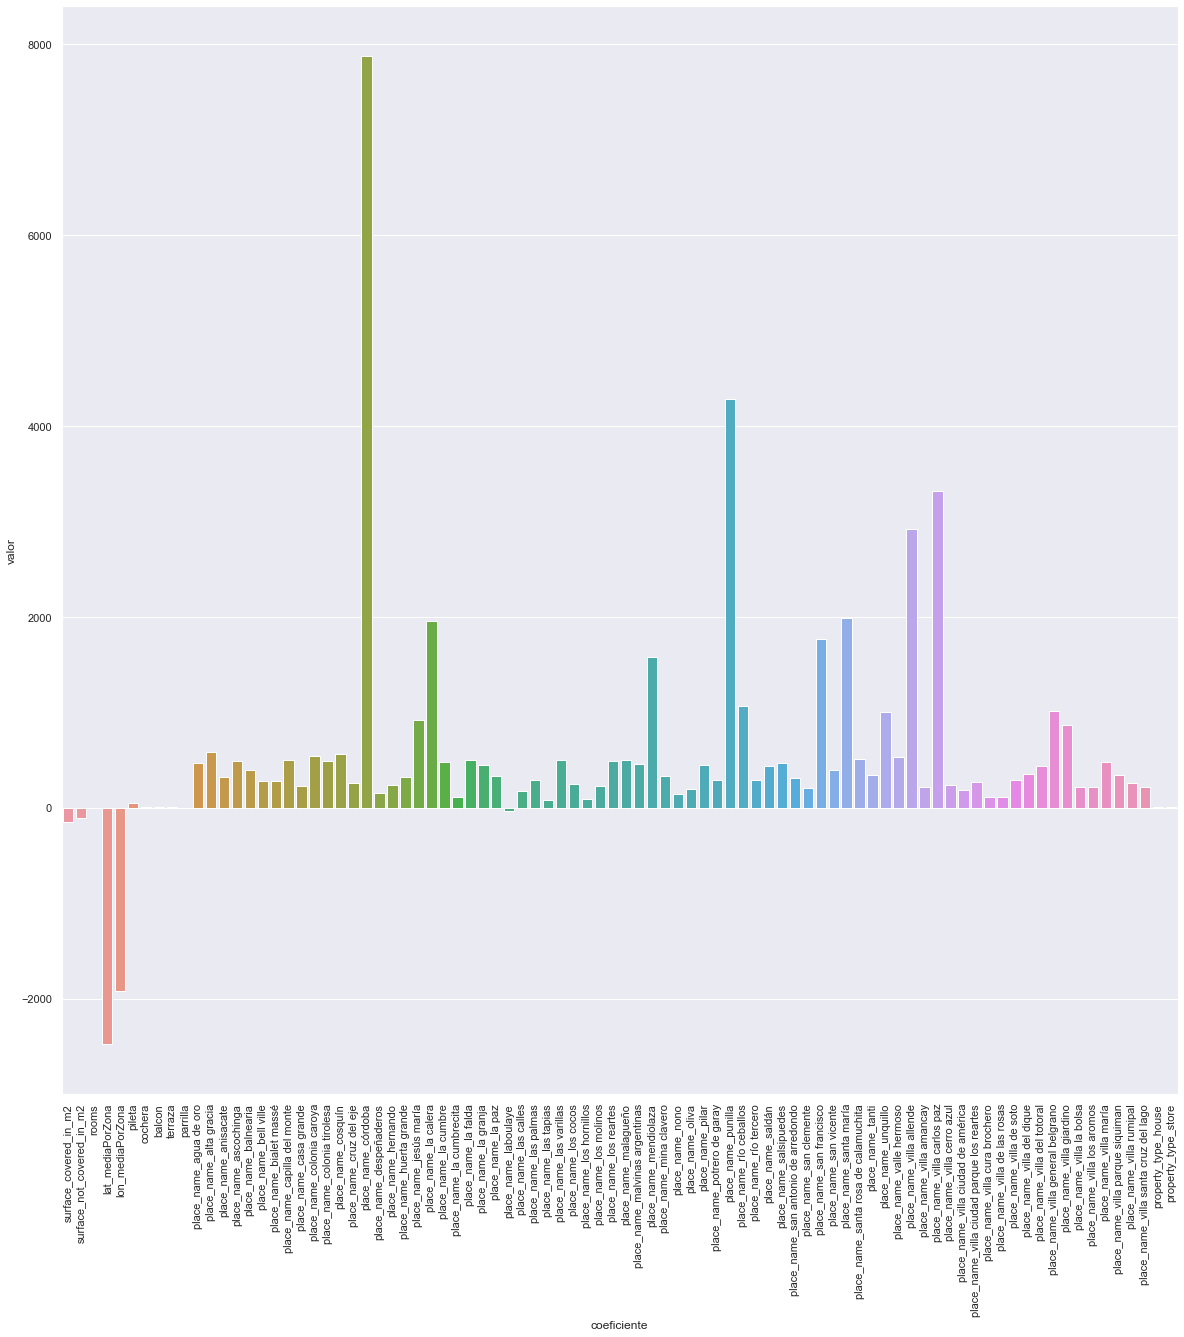

In [46]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_lineal);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

### Coeficientes RidgeCV

In [47]:
df_coeficientes_ridge = Desafio_2_aux.generateDataFrameFromModelCoeficients(model_ridge.coef_, X.columns)

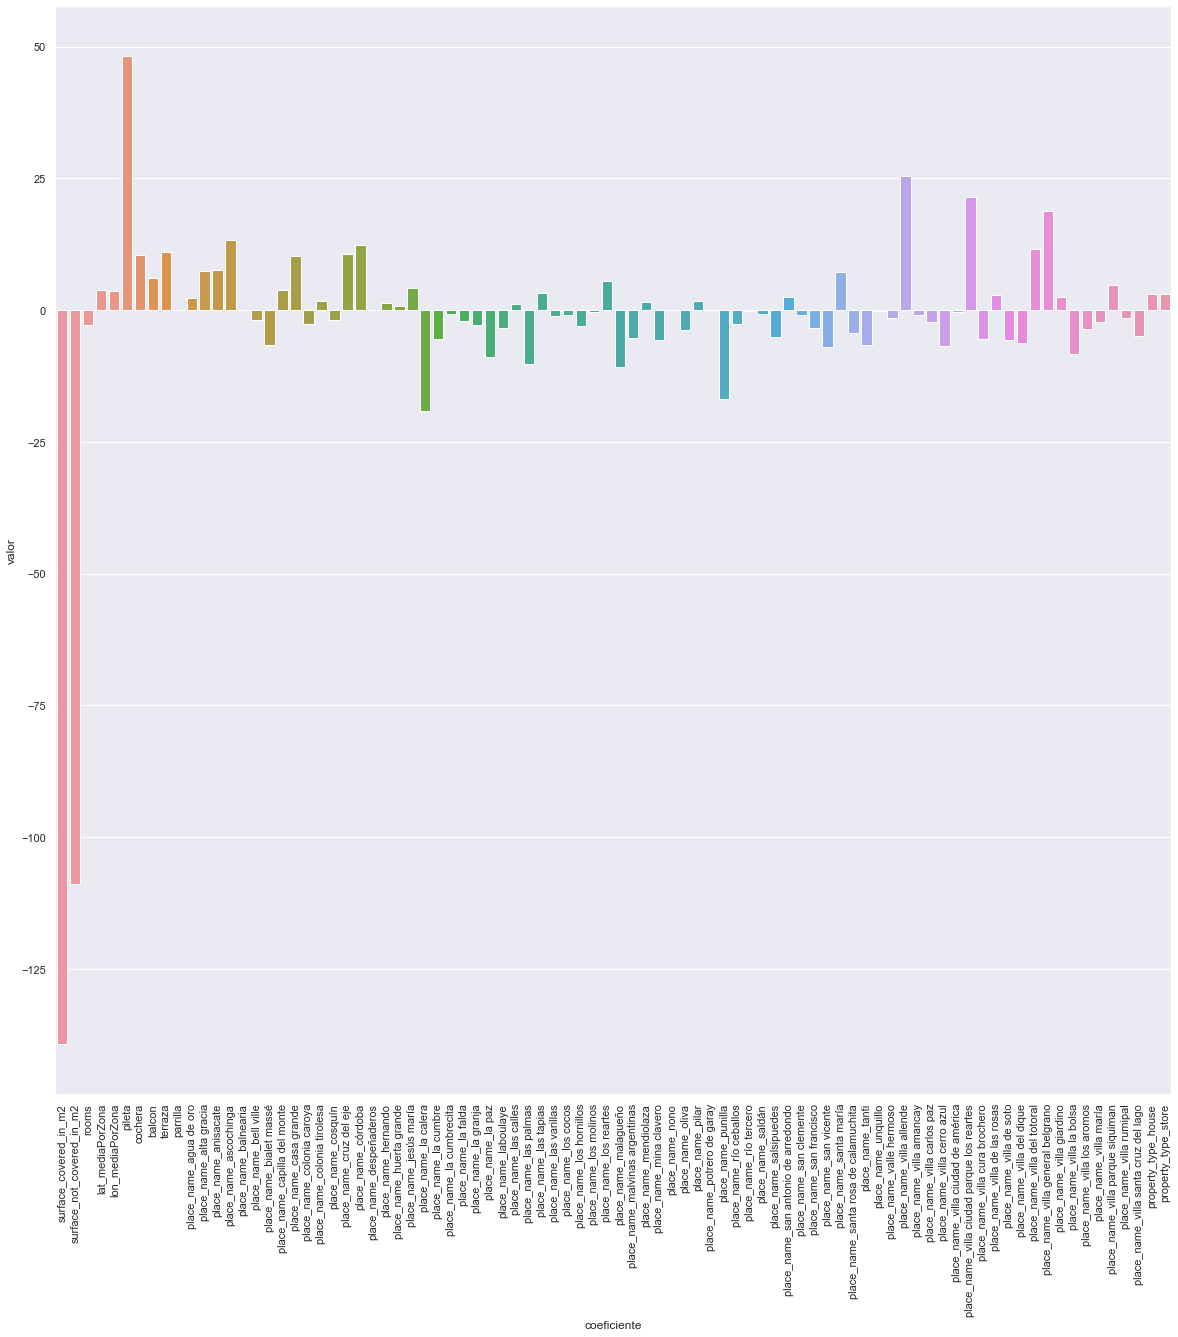

In [48]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_ridge);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

### Coeficientes para el modelo Lasso

In [49]:
df_coeficientes_lasso = Desafio_2_aux.generateDataFrameFromModelCoeficients(model_lasso.coef_, X.columns)

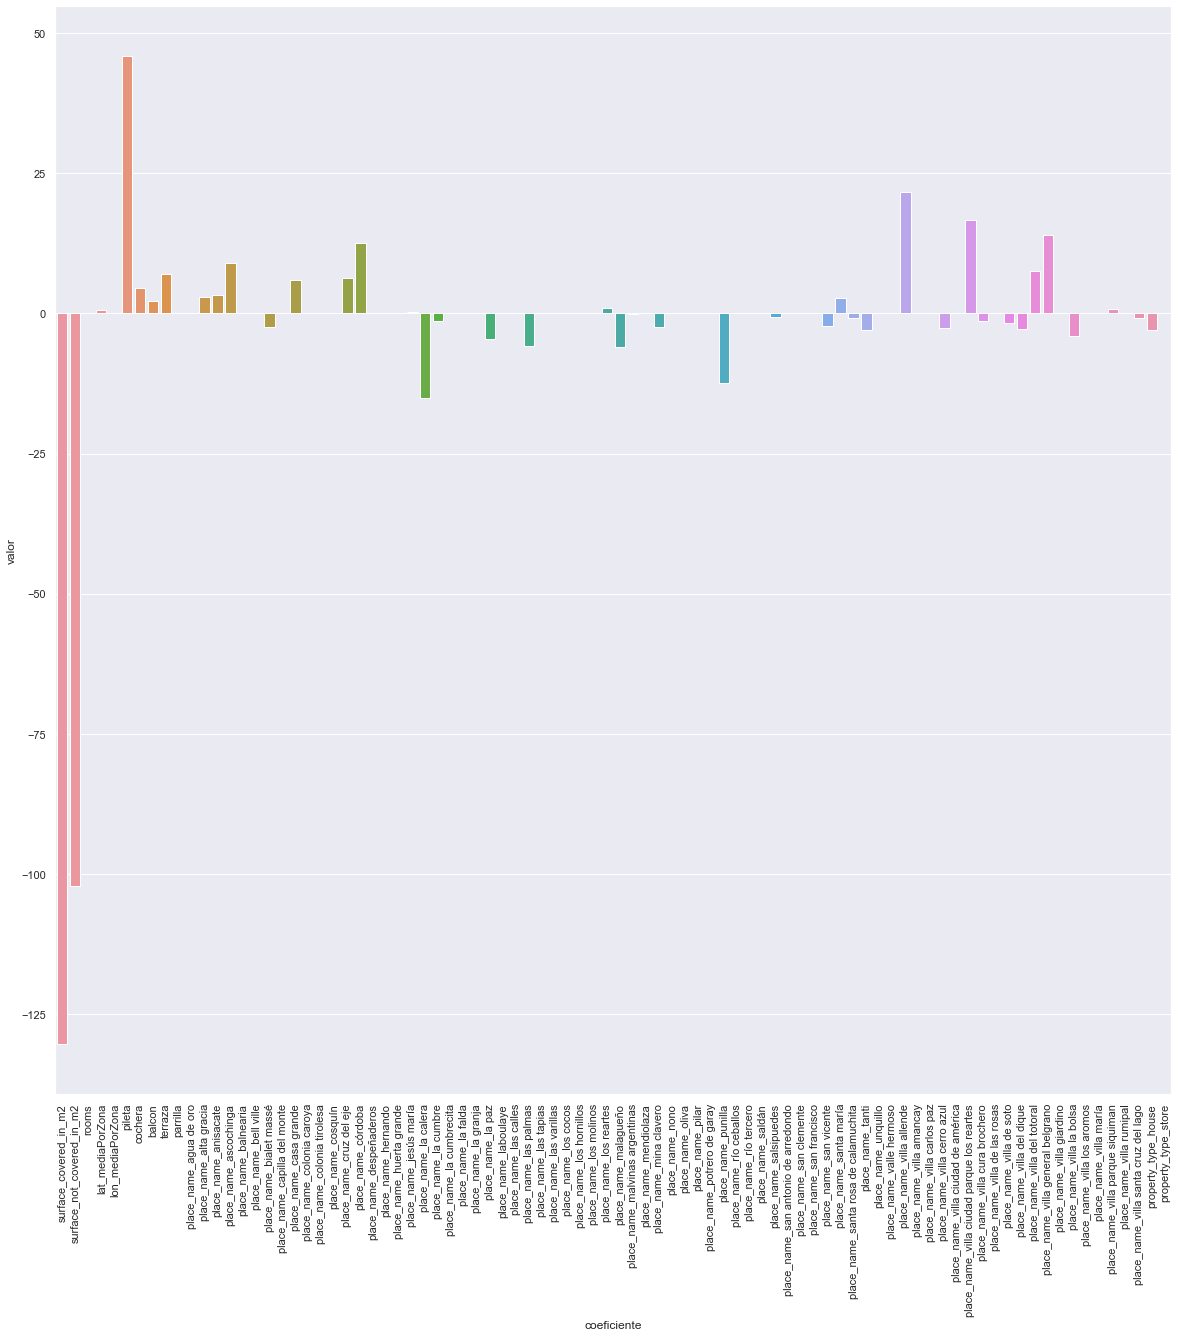

In [50]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_lasso);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

# Veamos como quedaron las relaciones entre los resultados predichos VS los resultados esperados

### Regresion Lineal

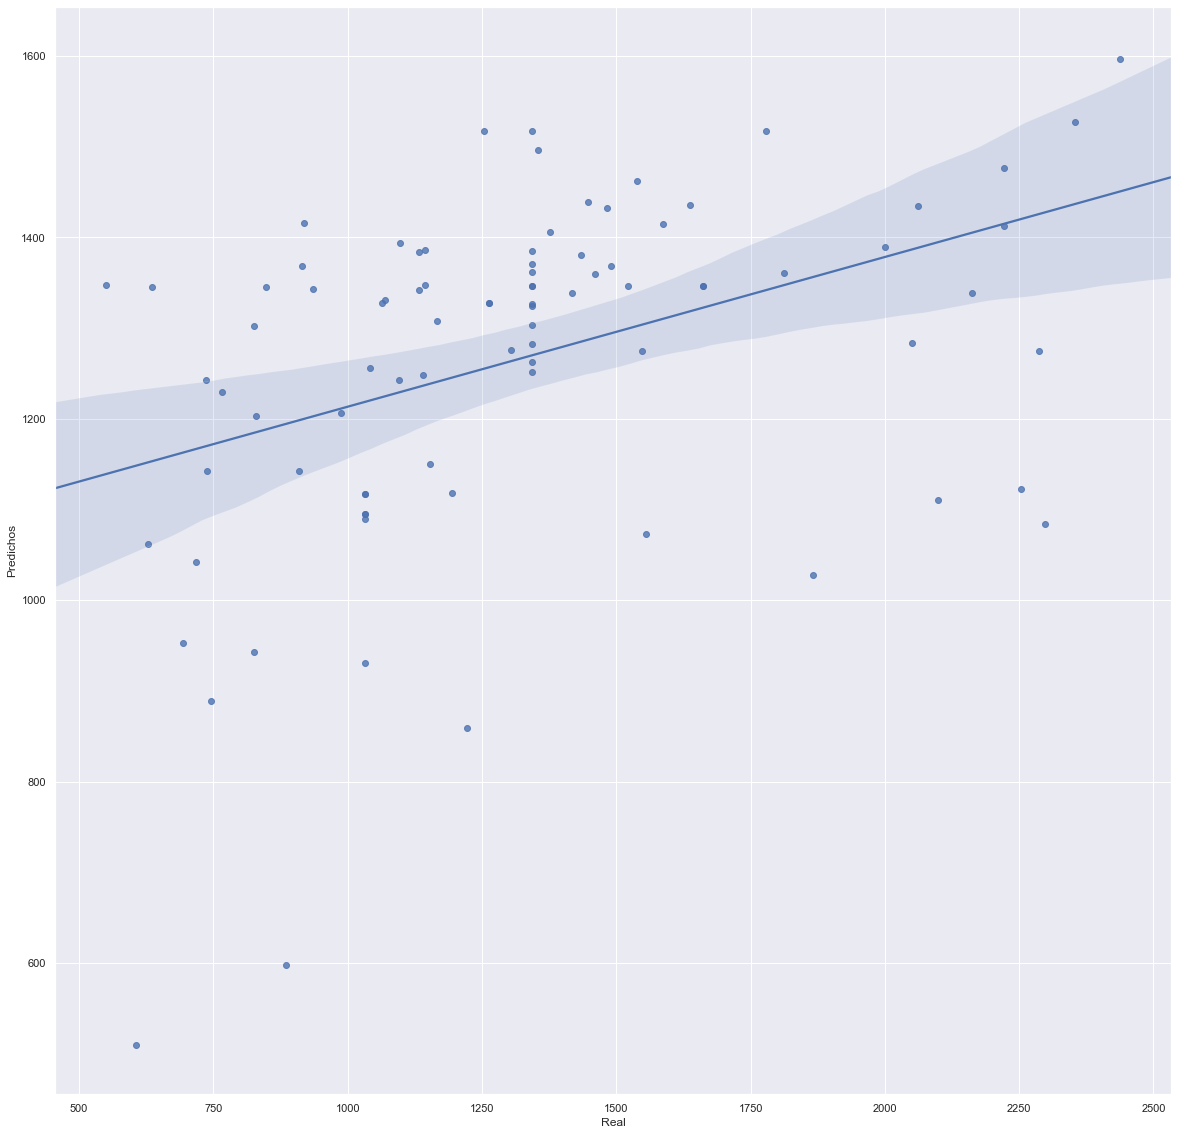

In [51]:
sns.regplot(df_regresion_lineal_prediccion_vs_real['Real'], df_regresion_lineal_prediccion_vs_real['Predichos'])

### Ridge CV

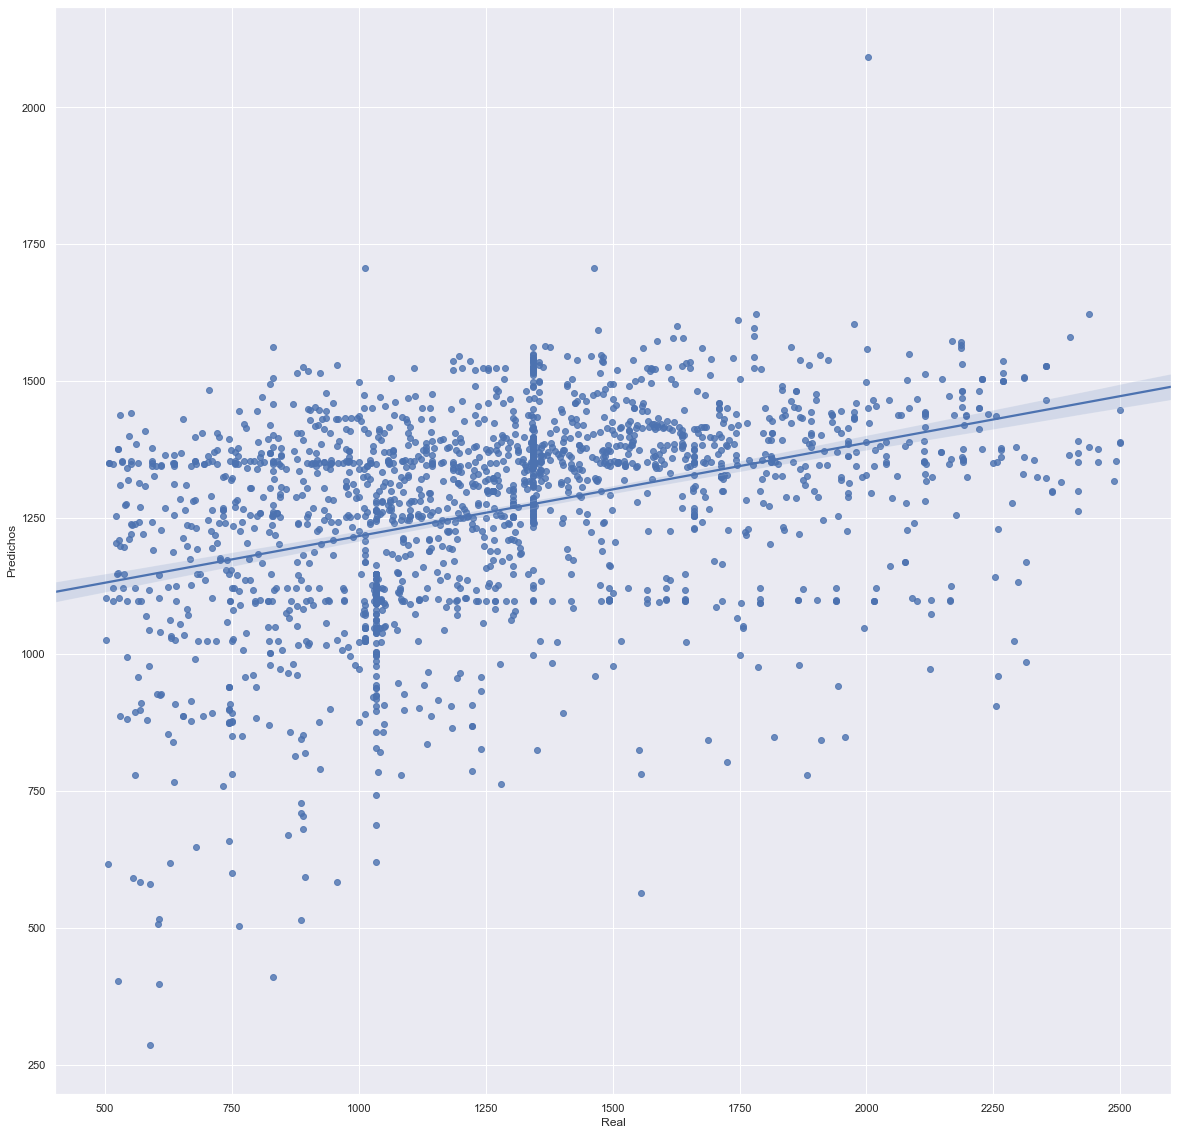

In [52]:
sns.regplot(df_ridge_prediccion_vs_real['Real'], df_ridge_prediccion_vs_real['Predichos'])

### Lasso

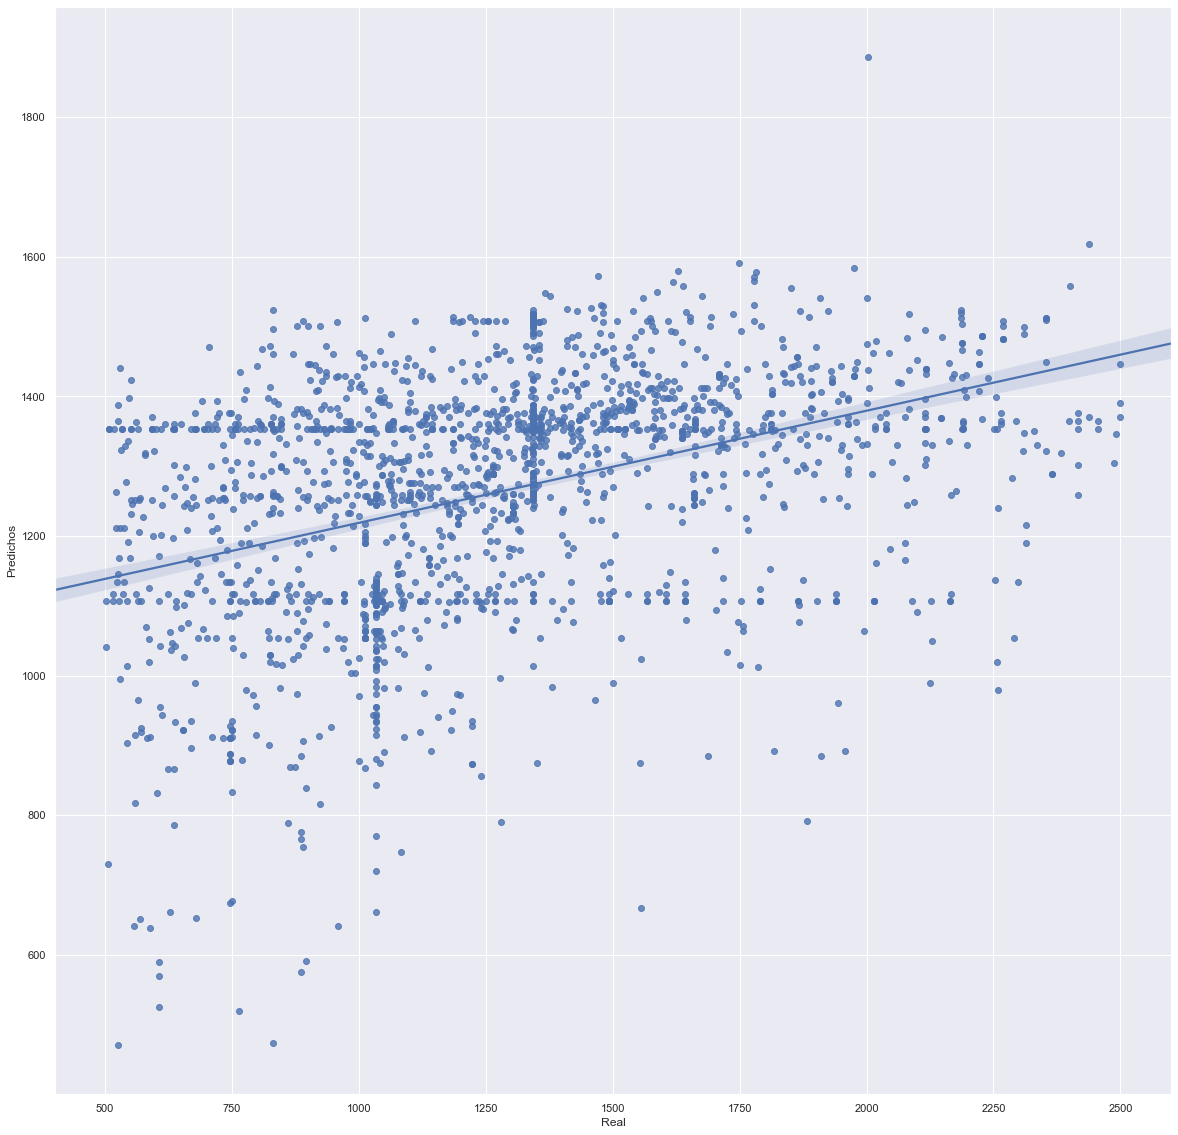

In [53]:
sns.regplot(df_lasso_prediccion_vs_real['Real'], df_lasso_prediccion_vs_real['Predichos'])

Una posible mejora que se puede agregar al análisis es ver la diferencia entre los valores predichos vs los valores reales por barrio. Para eso es necesario, cuando se hace el split para el entrenamiento y el testeo, que seleccione subconjuntos de acuerdo a las cantidades de filas para cada barrio. Porque por ejemplo el barrio de Palermo tiene mas de 2000 registros en el dataset, mientras que hay otros barrios, como Parque Chas, que no superan los 20